In [9]:
#using Pkg
#Pkg.add(PackageSpec(name="JWAS",rev="master"))
#Pkg.add("RecipesBase")
#using RecipesBase

In [10]:
# make plot work
#ENV["GRDIR"]=""
#Pkg.build("GR")

  Building GR → `/opt/julia/packages/GR/f1Iqi/deps/build.log`


In [ ]:
#methods(add_genotypes)

In [1]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

┌ Info: Recompiling stale cache file /opt/julia/compiled/v1.1/JWAS/tbeXw.ji for JWAS [c9a035f4-d403-5e6b-8649-6be755bc4798]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /opt/julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [5]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Exp_0.75_Complete.dat", types=Dict(:ID => String), delim = ' ',header=true, missingstrings=["NA"] )
#first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,Bool,String,String?
1,0001,1,1,1B,A,1B_1715,false,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,false,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,false,1B_D04,1B_D04
5,0006,1,1,1B,A,1B_1902,false,1B_D04,1B_D04
6,0007,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
7,0009,1,1,1B,A,1B_1902,false,1B_D02,1B_D02
8,0010,1,1,1B,A,1B_1885,false,1B_D02,1B_D02
9,0011,1,1,1B,A,1B_2097,false,1B_D02,1B_D02


In [6]:
phenotypes= dropmissing(phenotypes, :NurPenBatch)
phenotypes= dropmissing(phenotypes, :Died_Nur2)
phenotypes[!,:Died_Nur2]=phenotypes[!,:Died_Nur2] .+ 1

sort(phenotypes[!,:Died_Nur2])

3175-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [7]:
Died_Nur2_model_equations = "Died_Nur2 = intercept + Batch + EntryAge + NurPenBatch"
Died_Nur2_R=1.00000
Died_Nur2_model=build_model(Died_Nur2_model_equations,Died_Nur2_R);

In [8]:
set_covariate(Died_Nur2_model,"EntryAge")

1-element Array{Symbol,1}:
 :EntryAge

In [9]:
Died_Nur2_G1=0.535908E-01
set_random(Died_Nur2_model,"NurPenBatch",Died_Nur2_G1)

In [2]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 18.307029 seconds (37.77 k allocations: 10.393 GiB, 0.10% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [11]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))

3205-element Array{String,1}:
 "0001"
 "0002"
 "0004"
 "0005"
 "0006"
 "0007"
 "0009"
 "0010"
 "0011"
 "0012"
 "0013"
 "0014"
 "0015"
 ⋮     
 "3283"
 "3284"
 "3285"
 "3286"
 "3287"
 "3288"
 "3289"
 "3290"
 "3291"
 "3292"
 "3293"
 "3294"

In [12]:
Died_Nur2_G3=0.541156E-01
@time add_genotypes(Died_Nur2_model,M,Died_Nur2_G3,header=false, rowID=rowID)
#@time add_genotypes(Nur2ADG_model,"Geno_JWAS_impute.txt",Nur2ADG_G3,separator=' ')

The marker IDs are set to 1,2,...,#markers
#markers: 435172; #individuals: 3205
 15.705166 seconds (7.96 M allocations: 15.981 GiB, 1.49% gc time)


4.0f0

In [42]:
h2=Died_Nur2_G3/(Died_Nur2_G3+Died_Nur2_G1+ Died_Nur2_R)

0.04885373958297975

In [43]:
@time Died_Nur2_outCPi=runMCMC(Died_Nur2_model,phenotypes,methods="BayesC", missing_phenotypes=true,  categorical_trait = true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0



A Linear Mixed Model was build using model equations:

Died_Nur2 = intercept + Batch + EntryAge + NurPenBatch

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1
Batch           factor       fixed               50
EntryAge        covariate    fixed                1
NurPenBatch     factor       random             436

MCMC Information:

methods                                      BayesC
                              complete genomic data
                   (i.e., non-single-step analysis)
chain_length                                  50000
burnin                                         5000
estimatePi                                    false
estimateScale        

running MCMC for BayesC...100%|█████████████████████████| Time: 16:18:36




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


58738.955738 seconds (2.73 G allocations: 132.467 GiB, 0.07% gc time)


Dict{Any,Any} with 7 entries:
  "marker effects"          => 435172×5 DataFrame…
  "heritability"            => 1×3 DataFrame…
  "location parameters"     => 488×5 DataFrame…
  "residual variance"       => 1×3 DataFrame…
  "EBV_Died_Nur2"           => 3205×3 DataFrame…
  "genetic_variance"        => 1×3 DataFrame…
  "marker effects variance" => 1×3 DataFrame…

In [47]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration
mean(h2[!,:2])

0.038717287695909756

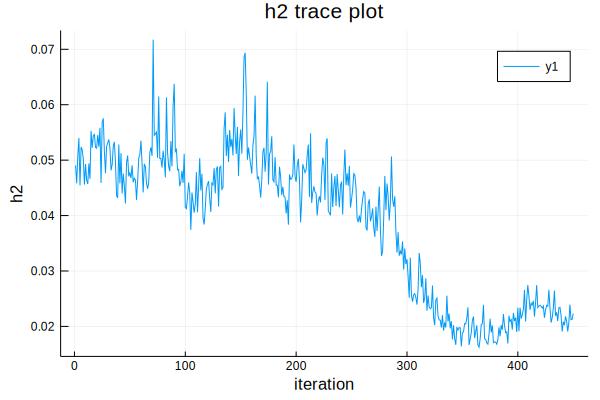

In [45]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [11]:
@time Died_Nur2_outCPi=runMCMC(Died_Nur2_model,phenotypes,methods="BayesC", missing_phenotypes=true, Pi= 0.999, categorical_trait = true, estimatePi=true, estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.


┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = recode at recode.jl:354 [inlined]
└ @ Core /opt/julia/packages/CategoricalArrays/xjesC/src/recode.jl:354



The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.001593



A Linear Mixed Model was build using model equations:

Died_Nur2 = intercept + Batch + EntryAge + NurPenBatch

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1
Batch           factor       fixed               50
EntryAge        covariate    fixed                1
NurPenBatch     factor       random             436

MCMC Information:

methods                                      BayesC
                              complete genomic data
                   (i.e., non-single-step analysis)
chain_length                                  50000
burnin                                         5000
estimatePi                                     true
estimateScale                                  true
starting_value                                false
printout_frequenc

running MCMC for BayesC...100%|█████████████████████████| Time: 12:00:07




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


43259.172699 seconds (1.68 G allocations: 110.953 GiB, 0.09% gc time)


Dict{Any,Any} with 9 entries:
  "marker effects"          => 435172×5 DataFrame…
  "Pi"                      => 1×3 DataFrame…
  "heritability"            => 1×3 DataFrame…
  "location parameters"     => 488×5 DataFrame…
  "residual variance"       => 1×3 DataFrame…
  "EBV_Died_Nur2"           => 3205×3 DataFrame…
  "ScaleEffectVar"          => 1×3 DataFrame…
  "genetic_variance"        => 1×3 DataFrame…
  "marker effects variance" => 1×3 DataFrame…

In [37]:
keys(Died_Nur2_outCPi)

Base.KeySet for a Dict{Any,Any} with 7 entries. Keys:
  "marker effects"
  "heritability"
  "location parameters"
  "residual variance"
  "EBV_Died_Nur2"
  "genetic_variance"
  "marker effects variance"

In [29]:
marker=CSV.read("MCMC_samples_genetic_variance.txt",delim = ' ',header=true)
Va=mean(marker[!, 1])

0.27746399883347106

In [30]:
pen=CSV.read("MCMC_samples_NurPenBatch_variances.txt",delim = ' ',header=true)
Vs=mean(pen[!, 1])

0.1599952974660908

In [31]:
Res=CSV.read("MCMC_samples_residual_variance.txt",delim = ' ',header=true)
Ve=mean(Res[!, 1])

1.0

In [32]:
h2=Va/(Va+Vs+Ve)

0.1930238995620565

In [36]:
Pi=Died_Nur2_outCPi["Pi"]

KeyError: KeyError: key "Pi" not found

In [34]:
Pi=CSV.read("MCMC_samples_pi.txt",delim = ' ',header=false)
insertcols!(Pi, 1, :iteration => 1:450) # Add a column called iteration

,iteration,Column1
,Int64,Float64
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


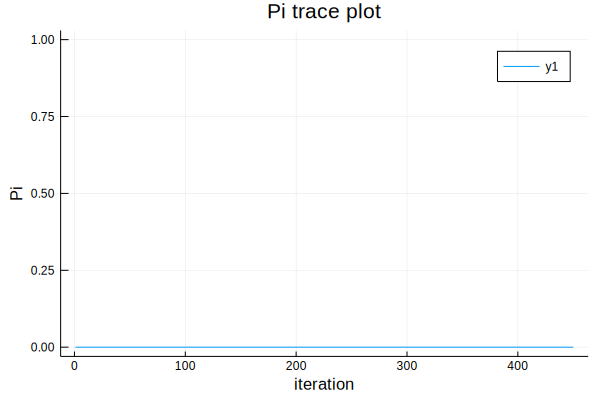

In [35]:
using Plots
x = Pi[!,1]; y = Pi[!,2]; # These are the plotting data
plot(x,y, title = "Pi trace plot",
        xlabel = "iteration", ylabel = "Pi")

In [20]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,Died_Nur2
,Int64,Float64
1,1,0.299582
2,2,0.278641
3,3,0.297677
4,4,0.245859
5,5,0.248851
6,6,0.306797
7,7,0.327538
8,8,0.307601
9,9,0.284969


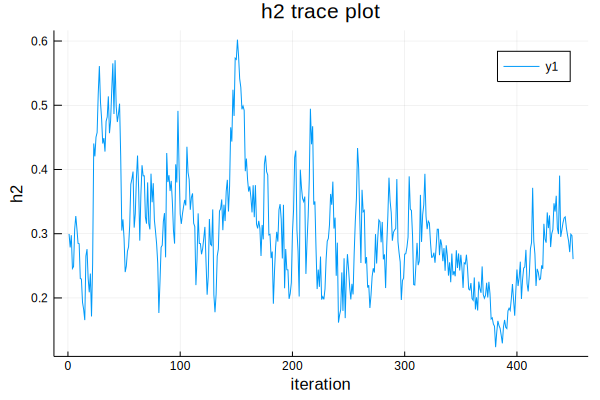

In [21]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [52]:
@time Died_Nur2_outB=runMCMC(Died_Nur2_model,phenotypes,methods="BayesB", missing_phenotypes=true, 
    Pi=0.999,estimateScale=true, categorical_trait = true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.000325



A Linear Mixed Model was build using model equations:

Died_Nur2 = intercept + Batch + EntryAge + NurPenBatch

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1
Batch           factor       fixed               50
EntryAge        covariate    fixed                1
NurPenBatch     factor       random             436

MCMC Information:

methods                                      BayesB
                              complete genomic data
                   (i.e., non-single-step analysis)
chain_length                                  50000
burnin                                         5000
estimatePi                                    false
estimateScale   

running MCMC for BayesB...100%|█████████████████████████| Time: 12:30:03




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


45022.508324 seconds (113.15 G allocations: 2.372 TiB, 0.84% gc time)


Dict{Any,Any} with 8 entries:
  "marker effects"          => 435172×5 DataFrame…
  "heritability"            => 1×3 DataFrame…
  "location parameters"     => 488×5 DataFrame…
  "residual variance"       => 1×3 DataFrame…
  "EBV_Died_Nur2"           => 3205×3 DataFrame…
  "ScaleEffectVar"          => 1×3 DataFrame…
  "genetic_variance"        => 1×3 DataFrame…
  "marker effects variance" => 1×3 DataFrame…

In [53]:
marker=CSV.read("MCMC_samples_genetic_variance.txt",delim = ' ',header=true)
Va=mean(marker[!, 1])

0.04828242307585472

In [54]:
pen=CSV.read("MCMC_samples_NurPenBatch_variances.txt",delim = ' ',header=true)
Vs=mean(pen[!, 1])

0.08794989037702151

In [55]:
Res=CSV.read("MCMC_samples_residual_variance.txt",delim = ' ',header=true)
Ve=mean(Res[!, 1])

1.0

In [56]:
h2=Va/(Va+Ve)

0.0460586021600793

In [57]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,Died_Nur2
,Int64,Float64
1,1,0.0456331
2,2,0.0526936
3,3,0.0403324
4,4,0.0858351
5,5,0.0424438
6,6,0.0459923
7,7,0.0472068
8,8,0.0393309
9,9,0.0576713


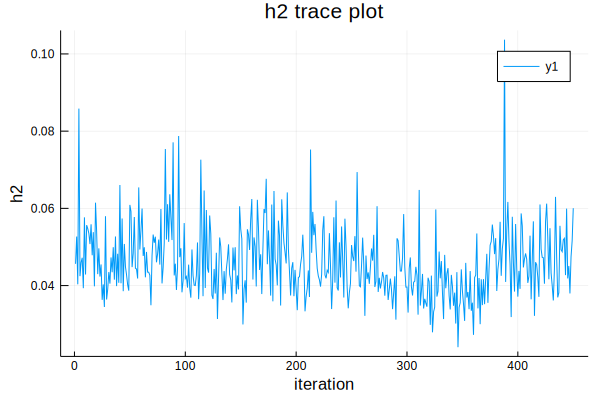

In [58]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [3]:
@time Died_Nur2_outB = GWAS("MCMC_samples_marker_effects_Died_Nur2.txt",
    "/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
    M;header=true,window_size="0.25 Mb",threshold=0.001)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:35:24


2176.778424 seconds (657.79 M allocations: 4.689 TiB, 11.49% gc time)


(9375×13 DataFrame. Omitted printing of 7 columns
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┤
│ 1    │ 1     │ 7321   │ 14     │ 46750000  │ 47000000  │ 46752865  │
│ 2    │ 1     │ 7319   │ 14     │ 46250000  │ 46500000  │ 46250370  │
│ 3    │ 1     │ 7324   │ 14     │ 47500000  │ 47750000  │ 47505397  │
│ 4    │ 1     │ 3190   │ 6      │ 2750000   │ 3000000   │ 2750136   │
│ 5    │ 1     │ 7207   │ 14     │ 18250000  │ 18500000  │ 18254655  │
│ 6    │ 1     │ 5523   │ 10     │ 15500000  │ 15750000  │ 15502709  │
│ 7    │ 1     │ 7314   │ 14     │ 45000000  │ 45250000  │ 45001414  │
│ 8    │ 1     │ 287    │ 1      │ 71500000  │ 71750000  │ 71500926  │
│ 9    │ 1     │ 5005   │ 9      │ 25250000  │ 25500000  │ 25253728  │
│ 10   │ 1     │ 7320   │ 14     │ 46500000  │ 46750000  │ 46501477  │
⋮
│ 9365 │ 1     │ 9363   │

In [4]:
Died_Nur2_outB= Died_Nur2_outB[:1]

,trait,window,chr,wStart,wEnd,start_SNP,end_SNP,numSNP,estimateGenVar
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64
1,1,7321,14,46750000,47000000,46752865,46998737,55,7.65708e-5
2,1,7319,14,46250000,46500000,46250370,46499201,61,0.000117878
3,1,7324,14,47500000,47750000,47505397,47744426,50,3.82653e-5
4,1,3190,6,2750000,3000000,2750136,2999538,83,1.26505e-5
5,1,7207,14,18250000,18500000,18254655,18496949,64,1.71514e-5
6,1,5523,10,15500000,15750000,15502709,15745543,65,4.10549e-5
7,1,7314,14,45000000,45250000,45001414,45240098,59,0.000148733
8,1,287,1,71500000,71750000,71500926,71746605,69,1.45263e-5
9,1,5005,9,25250000,25500000,25253728,25499833,81,3.79926e-5


In [44]:
insertcols!(Died_Nur2_outB, 11, :prGenVar2 => Died_Nur2_outB[!, 9]/sum(Died_Nur2_outB[!, 9]))

ArgumentError: ArgumentError: Column prGenVar2 is already present in the data frame which is not allowed when `makeunique=true`

In [39]:
Died_Nur2_outB[:9:12]

┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = top-level scope at In[39]:1
└ @ Core In[39]:1


,estimateGenVar,stdGenVar,prGenVar2,prGenVar
,Float64,Float64,Float64,Float64
1,0.000283717,0.00130545,0.00587536,0.52
2,0.000284919,0.00154922,0.00590025,0.52
3,5.39914e-5,0.000218769,0.00111808,0.12
4,4.36978e-5,0.000169831,0.000904915,0.09
5,7.65268e-5,0.000334849,0.00158476,0.15
6,6.43784e-5,0.000296814,0.00133318,0.14
7,4.05699e-5,0.000160289,0.000840142,0.09
8,3.20932e-5,0.000115971,0.000664601,0.07
9,9.1843e-5,0.000697634,0.00190193,0.18


In [5]:
CSV.write("MCMC_samples_0.25Mb_window_VarProps_Died_Nur2.txt", Died_Nur2_outB)

"MCMC_samples_0.25Mb_window_VarProps_Died_Nur2.txt"

In [ ]:
#marker_effects = GWAS("MCMC_samples_marker_effects_FinADG.txt";header=true) # probability of inclusion

In [ ]:
#Nur2_ADG_outBPi = GWAS("MCMC_samples_marker_effects_Nur2ADG.txt",Nur2ADG_model;header=true,window_size=20,threshold=0.001,output_winVarProps=false)  # No map

In [ ]:
#using DelimitedFiles
#VL_winVarProps=readdlm("JWAS-WG/Haplotype/MCMC_samples_1MbwindowVarProps_Haplotype_WG-BayesB.txt", '\t',header=false)

In [ ]:
#res = VL_winVarProps .> 2/2400
#ppa = sum(res,dims=1)./450

In [ ]:
#ppa[1, [261 755 1352 2185]]

In [ ]:
#sort(vec(ppa))